# Sales Prediction Based on Advertisement II

This project aims to predict with little error the sales a company will make if it invests in different media of advertisment. The dataset treated displays sales (in thousands of units) for a particular product as a function of advertising budgets (in thousands of dollars) for TV, radio, and newspaper media.

The project is carried out using the Multiple Linear Regression.

## Steps

* Libraries Importing 
* Data Importing 
* Data Wrangling
* Data Visualization
* Model Creation
* Model parameters tuning
* Prediction

## Libraries Importing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.metrics import mean_squared_error

## Data Importing

In [3]:
df = pd.read_csv("Advertising.csv")

## Data Wrangling

In [4]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [6]:
df.isna().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

There are no missing data and all columns are of the float datatype. The distribution of each variable will be assessed during the data visualization step

In [7]:
df["Total_spend"] = df["TV"] + df["radio"] + df["newspaper"]
df

,TV,radio,newspaper,sales,Total_spend
0,230.1,37.8,69.2,22.1,337.1
1,44.5,39.3,45.1,10.4,128.9
2,17.2,45.9,69.3,9.3,132.4
3,151.5,41.3,58.5,18.5,251.3
4,180.8,10.8,58.4,12.9,250.0
...,...,...,...,...,...
195,38.2,3.7,13.8,7.6,55.7
196,94.2,4.9,8.1,9.7,107.2
197,177.0,9.3,6.4,12.8,192.7
198,283.6,42.0,66.2,25.5,391.8


## Data Visualization

<Figure size 800x800 with 0 Axes>

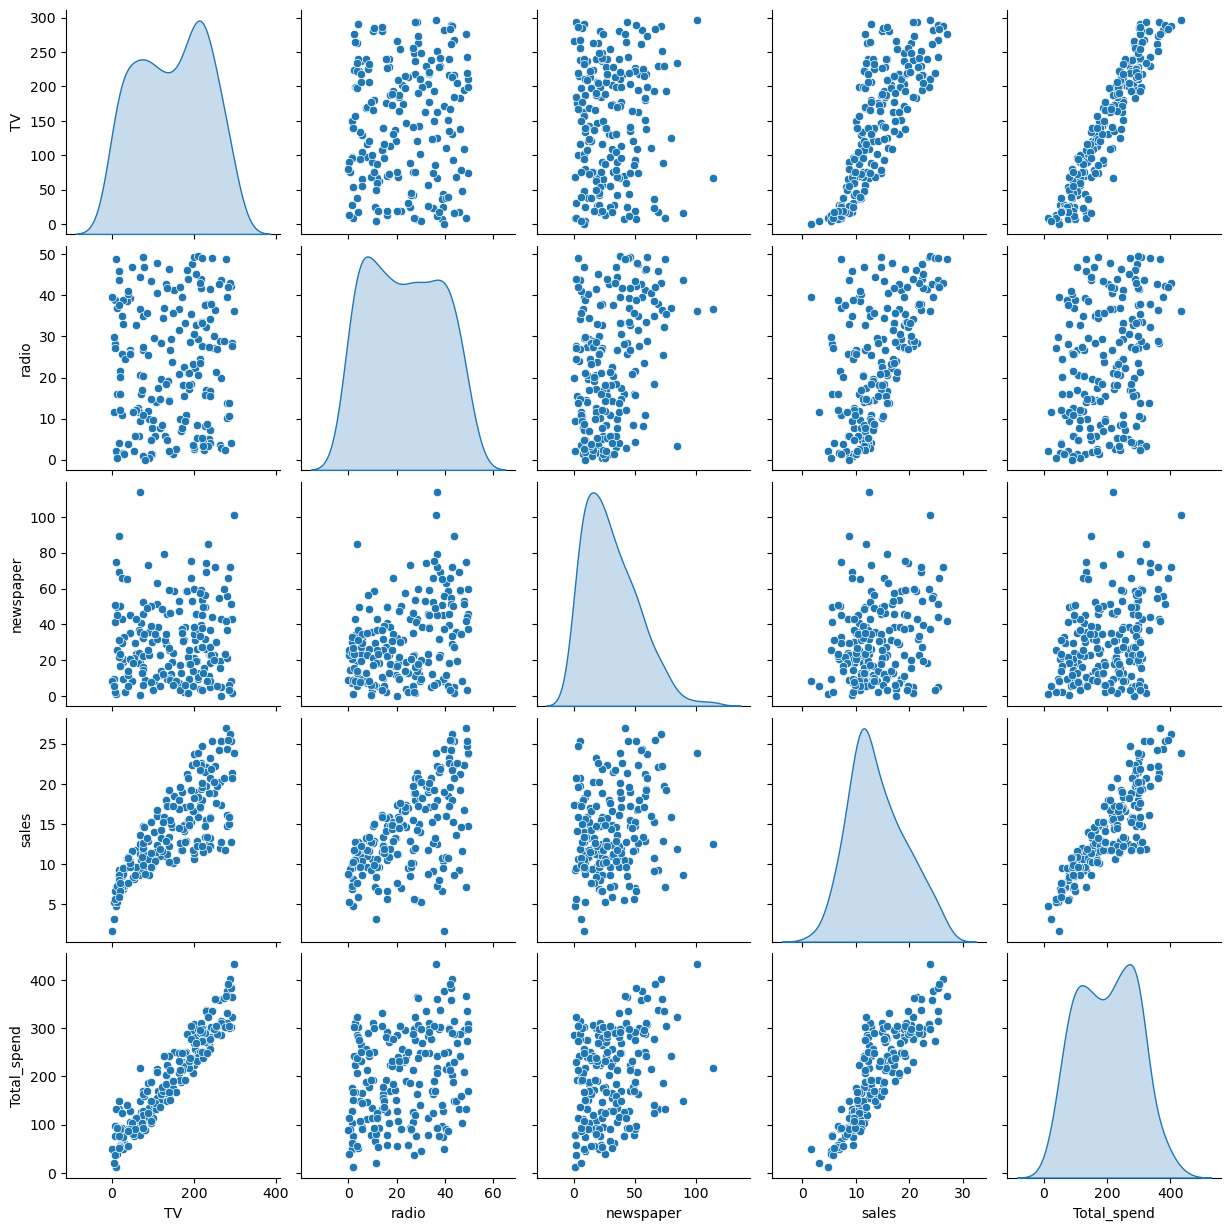

In [8]:
plt.figure(figsize=(8,8))
sns.pairplot(df, diag_kind='kde')

The assumption that the sales depends alone on the total spend could be termed a rather crude one and to get a better fit, an interaction might be necessary between the various different adevrtising platforms

Text(0, 0.5, 'Sales')

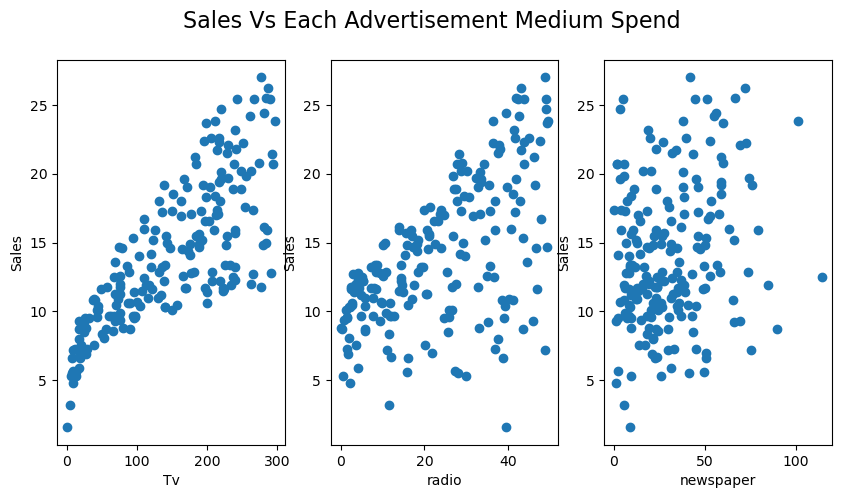

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5), dpi=100)
fig.suptitle("Sales Vs Each Advertisement Medium Spend",fontsize=16)

axes[0].scatter(data=df,x="TV",y="sales")
axes[0].set_xlabel("Tv")
axes[0].set_ylabel("Sales")

axes[1].scatter(data=df,x="radio",y="sales")
axes[1].set_xlabel("radio")
axes[1].set_ylabel("Sales")

axes[2].scatter(data=df,x="newspaper",y="sales")
axes[2].set_xlabel("newspaper")
axes[2].set_ylabel("Sales")

It is obvious from the plots above that there seems to be a variance in the correlation of the sales to each of the advertisement media. This can further be strengthened numerically with the results below.

In [18]:
df.corr()["sales"]

TV             0.782224
radio          0.576223
newspaper      0.228299
sales          1.000000
Total_spend    0.867712
Name: sales, dtype: float64

Some form of specific interactions may then aid make better results

# Model Creation and Parameters Tuning I

First, we create a linear model using the sales by the combination of the different adevertisement media (Interactions) and then repeat the same process with different powers of spend to get the value with the least test RMSE, tuning degree parameter.

In [19]:
X = df.drop(['sales', 'Total_spend'],axis=1)
y = df["sales"]

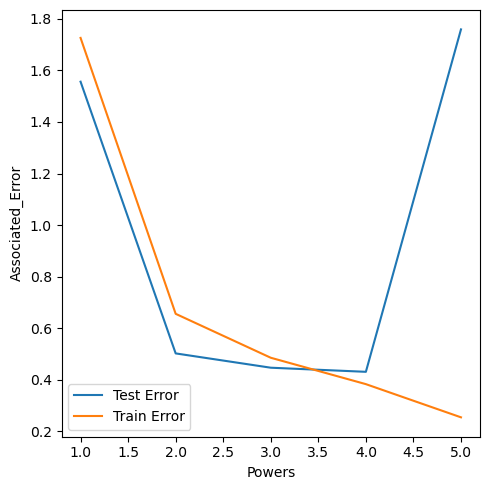

In [20]:
#(Multiple variables == General additive methods) using powers from 1

test_error_list = []
train_error_list = []

for i in range(1,6):
    #Converting the veriable to the polynomial form to allow for interactions
    X_poly = PolynomialFeatures(degree=i, include_bias=False)
    X_poly = X_poly.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.33, random_state=5)
    
    #Fit the data to a linear regression line after scaling
    
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    lr = LinearRegression()
    lr.fit(scaled_X_train,y_train)
    y_pred_test = lr.predict(scaled_X_test)
    y_pred_train = lr.predict(scaled_X_train)
     
    test_error_list.append(np.sqrt(mean_squared_error(y_test,y_pred_test)))
    train_error_list.append(np.sqrt(mean_squared_error(y_train,y_pred_train)))    
    
ranger = np.arange(1,6)

plt.figure(figsize=(5,5))
plt.plot(ranger,test_error_list, label="Test Error")
plt.plot(ranger,train_error_list, label="Train Error")
plt.xlabel("Powers")
plt.ylabel("Associated_Error")
plt.legend()
plt.tight_layout();

In [21]:
X_poly.shape

(200, 55)

# Model Parameters Tuning II
We also repeat the same process with different splines to get the value with the least test RMSE, tuning degree and n_knots parameters

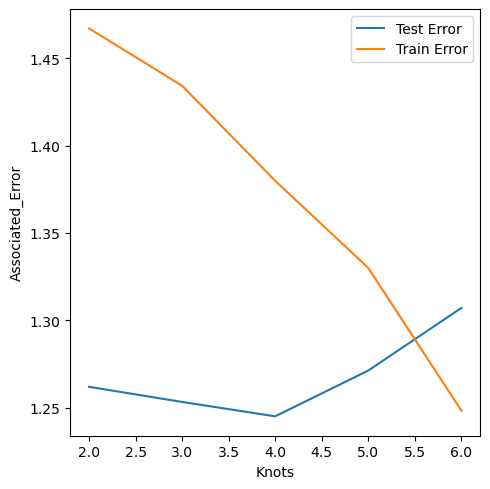

In [22]:
def maintain_range(inp_array,beg,end):
    
    index = 0
    
    for i in inp_array:
        if i < beg or i > end:
            
            inp_array = np.delete(inp_array, index)
            
            index -= 1
        
        index += 1
    
    return inp_array

test_error_list_s = []
train_error_list_s = []


for i in range(2,7):
    
    #Converting the x to the spline form defining the degree and necessary parameters
    X_spline = SplineTransformer(degree=3, n_knots=i).fit(X)
    X_spline = X_spline.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_spline, y, test_size=0.33, random_state=5)
    
    #Fit the data to a linear regression line
    lr_s = LinearRegression()
    lr_s.fit(X_train,y_train)
    y_pred_test = lr_s.predict(X_test)
    y_pred_train = lr_s.predict(X_train)
    
    
    test_error_list_s.append(np.sqrt(mean_squared_error(y_test,y_pred_test)))
    train_error_list_s.append(np.sqrt(mean_squared_error(y_train,y_pred_train)))
    
ranger = np.arange(2,7)

plt.figure(figsize=(5,5))
plt.plot(ranger,test_error_list_s, label="Test Error")
plt.plot(ranger,train_error_list_s, label="Train Error")

plt.xlabel("Knots")
plt.ylabel("Associated_Error")
plt.legend()
plt.tight_layout();

From the parameters' tuning, we realise that the best polynomial model is that with the 4th degree and the number of knots with the least RMSE is 4. Therefore for both situations, the optimal number is 4.

Although its observed that both models reduce the test error, the first model having about 34 variables is rather unrealistic. The inclusion of such number of variables can cause the addition of noise and therefore it is necessary to choose the most useful interactions. This will be done using the Lasso Regression.

In [23]:
X_poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = X_poly.fit_transform(X)
    
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.33, random_state=5)
 
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)    

In [24]:
X_poly.shape

(200, 34)

In [25]:
lasso_model = Lasso()

In [26]:
alpha = list(np.linspace(0.001, 100, 10000))
param = {
    "alpha":alpha,
}

In [27]:
grid = GridSearchCV(estimator=lasso_model, param_grid=param)

In [28]:
grid.fit(scaled_X_train, y_train)

C:\Users\hp pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.758e+00, tolerance: 3.141e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\hp pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.169e-01, tolerance: 2.980e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\hp pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.449e+00, toleranc

KeyboardInterrupt: 

In [57]:
grid.best_estimator_

Lasso(alpha=0.011000900090009001)

In [58]:
new_lasso = Lasso(alpha=0.011)

In [59]:
new_lasso.fit(scaled_X_train, y_train)

Lasso(alpha=0.011)

In [64]:
new_lasso.coef_

array([ 4.73974535,  0.41575501,  0.12930007, -3.55968538,  3.78909341,
       -0.01439357,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.15277204,  0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.55137213,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.03477126,  0.01055235,  0.        ,  0.        ])

In [71]:
new_lasso.coef_[new_lasso.coef_ != 0].shape

(10,)

In [70]:
y_pred_test = new_lasso.predict(scaled_X_test)
np.sqrt(mean_squared_error(y_test, y_pred_test))

0.44540796967314766

It is thus observed that the number of features has been reduced from 34 to 10 and it reflects the useful interactions.

In [37]:
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)
scaler_poly = StandardScaler()
scaled_X = scaler_poly.fit_transform(X_poly)
    
lr = LinearRegression()
lr.fit(scaled_X,y)

LinearRegression()

In [38]:
spline = SplineTransformer(degree=3, n_knots=4)
X_spline = spline.fit_transform(X)
scaler_spline = StandardScaler()
scaled_X_spline = scaler_spline.fit_transform(X_spline)
    
lr_s = LinearRegression()
lr_s.fit(scaled_X_spline,y)

LinearRegression()

In [39]:
X_poly.shape

(200, 34)

In [40]:
X_spline.shape

(200, 18)

In [85]:
lasso = Lasso(alpha=0.011)
lasso.fit(scaled_X, y)

Lasso(alpha=0.011)

# Prediction
We get the prediction of sales based on new data points

| Tv | Radio | Newspaper |
|:--------:|:--------:|:--------:|
|  23   |  34   |  10   |
|  10   |  35   |  12   |


In [75]:
new_point = np.array([[23, 34, 10], [10, 35, 12]])

We then use the models to tranform the new data points

In [89]:
total_poly = scaler_poly.transform(poly.transform(new_point))
lr.predict(total_poly)

C:\Users\hp pc\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([8.02280532, 5.97677187])

In [95]:
total_spline = scaler_spline.transform(spline.transform(new_point))
lr_s.predict(total_spline)

C:\Users\hp pc\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SplineTransformer was fitted with feature names
  warnings.warn(


array([9.17899649, 7.10659613])

In [90]:
lasso.predict(total_poly)

array([8.17295706, 7.14602348])

We observe that the outputs in thousand of units for the three models are somewhat varied. The Lasso Regression Model is the preferred choice in this situation